In [1]:
import cv2
import csv
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image 
import argparse



In [2]:
!pip3 install chainer chainer-cv


     |████████████████████████████████| 1.0 MB 7.1 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=5fc0273bf0308f3983fc11ca1f7993f37b3bba8ea201ef7a11a3c5ab7e3f96d9
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


In [3]:
import chainer

/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [9]:
!pip install 'cupy-cuda111>=7.7.0,<8.0.0'

ERROR: Could not find a version that satisfies the requirement cupy-cuda111<8.0.0,>=7.7.0 (from versions: 8.1.0, 8.2.0, 8.3.0, 8.4.0, 8.5.0, 8.6.0, 9.0.0a1, 9.0.0a2, 9.0.0b1, 9.0.0b2, 9.0.0b3, 9.3.0, 9.4.0, 9.5.0, 9.6.0, 10.0.0)
ERROR: No matching distribution found for cupy-cuda111<8.0.0,>=7.7.0


In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
folder_img = '/content/drive/MyDrive/ai/imagenes/'
folder_faces = '/content/drive/MyDrive/ai/faces/'
tags_file = '/content/drive/MyDrive/ai/Etiquetado.csv'

In [11]:
%cd /content/
!rm -rf noticias
!git clone https://github.com/alvaro-neira/noticias.git --branch exploring
%cd noticias/
!git fetch --all
!git pull origin exploring
!git submodule init
!git submodule update

/content
Cloning into 'noticias'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (429/429), done.
remote: Compressing objects: 100% (303/303), done.
remote: Total 429 (delta 221), reused 319 (delta 114), pack-reused 0
Receiving objects: 100% (429/429), 205.24 MiB | 16.06 MiB/s, done.
Resolving deltas: 100% (221/221), done.
/content/noticias
Fetching origin
From https://github.com/alvaro-neira/noticias
 * branch            exploring  -> FETCH_HEAD
Already up to date.
Submodule 'Gender-and-Age-Detection' (https://github.com/alvaro-neira/Gender-and-Age-Detection.git) registered for path 'Gender-and-Age-Detection'
Submodule 'hyperface' (https://github.com/alvaro-neira/hyperface.git) registered for path 'hyperface'
Cloning into '/content/noticias/Gender-and-Age-Detection'...
Cloning into '/content/noticias/hyperface'...
Submodule path 'Gender-and-Age-Detection': checked out 'b570b6f4c7f27af2b9c8f2fe36ba112b42f4dcb2'
Submodule path 'hyperface': checked out '903a89e5

In [12]:
!ls /content/drive/MyDrive/ai

'Copy of Etiquetado-Paula.gsheet'   faces	     'test etiquetado.gsheet'
 copy_of_paula.gsheet		    imagenes
 Etiquetado.csv			    model_epoch_190


In [13]:
!ls /content/drive/MyDrive/ai/faces

tv24horas_2021_10_26_22_face1.png  tv24horas_2021_11_23_22_face1.png
tv24horas_2021_10_27_03_face1.png  tv24horas_2021_11_24_02_face1.png
tv24horas_2021_10_27_05_face1.png  tv24horas_2021_11_24_04_face1.png
tv24horas_2021_10_27_11_face1.png  tv24horas_2021_11_24_19_face1.png
tv24horas_2021_10_27_12_face1.png  tv24horas_2021_11_25_06_face1.png
tv24horas_2021_10_27_16_face1.png  tv24horas_2021_11_26_24_face1.png
tv24horas_2021_10_28_11_face1.png  tv24horas_2021_11_27_02_face1.png
tv24horas_2021_10_28_12_face1.png  tv24horas_2021_11_28_02_face1.png
tv24horas_2021_10_28_19_face1.png  tv24horas_2021_11_28_16_face1.png
tv24horas_2021_10_28_23_face1.png  tv24horas_2021_11_28_20_face1.png
tv24horas_2021_10_29_12_face1.png  tv24horas_2021_11_29_20_face1.png
tv24horas_2021_10_29_17_face1.png  tv24horas_2021_11_30_05_face1.png
tv24horas_2021_10_29_18_face1.png  tv24horas_2021_11_30_13_face1.png
tv24horas_2021_10_29_19_face1.png  tv24horas_2021_12_01_02_face1.png
tv24horas_2021_10_29_21_face1.png 

In [14]:
%cd /content/noticias/hyperface/scripts

/content/noticias/hyperface/scripts


In [24]:
import chainer

import cv2
import os
import numpy as np

import config

# Disable type check in chainer
import models

os.environ["CHAINER_TYPE_CHECK"] = "0"


def _cvt_variable(v):
    # Convert from chainer variable
    if isinstance(v, chainer.variable.Variable):
        v = v.data
        if hasattr(v, 'get'):
            v = v.get()
    return v


def short_hyperface(config_path, img_path, model_path):
    # Load config
    config.load(config_path)

    # Define a model
    model = models.HyperFaceModel()
    model.train = False
    model.report = False
    model.backward = False

    # Initialize model
    chainer.serializers.load_npz(model_path, model)

    # Setup GPU
    if config.gpu >= 0:
        chainer.cuda.check_cuda_available()
        chainer.cuda.get_device(config.gpu).use()
        model.to_gpu()
        xp = chainer.cuda.cupy
    else:
        xp = np

    # Load image file
    img = cv2.imread(img_path)
    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        exit()
    img = img.astype(np.float32) / 255.0  # [0:1]
    img = cv2.resize(img, models.IMG_SIZE)
    img = cv2.normalize(img, None, -0.5, 0.5, cv2.NORM_MINMAX)
    img = np.transpose(img, (2, 0, 1))

    # Create single batch
    imgs = xp.asarray([img])
    x = chainer.Variable(imgs)  # , volatile=True)

    # Forward
    y = model(x)

    # Chainer.Variable -> np.ndarray
    detection = _cvt_variable(y['detection'])
    genders = _cvt_variable(y['gender'])

    gender = genders[0]

    if gender > 0.5:
        return f"Female, detection={detection}"
    else:
        return f"Male, detection={detection}"

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
print(short_hyperface('/content/noticias/hyperface/scripts/config.json','/content/drive/MyDrive/ai/faces/tv24horas_2021_12_07_01_face1.png','/content/drive/MyDrive/ai/model_epoch_190'))

Male, detection=[0.9912403]


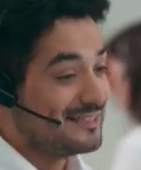

Male, detection=[0.9950531]





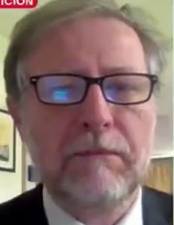

Male, detection=[0.9816638]





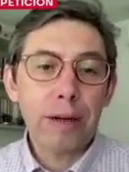

Male, detection=[0.98280025]





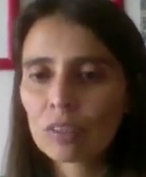

Female, detection=[0.9902113]





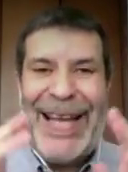

Male, detection=[0.9039277]





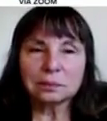

Female, detection=[0.99826044]





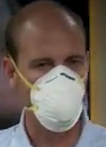

Male, detection=[0.9821844]





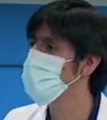

Male, detection=[0.00148441]





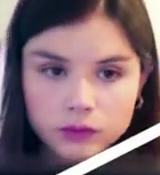

Female, detection=[0.9785422]





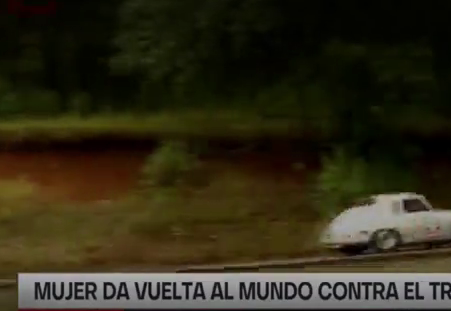

Female, detection=[2.7291204e-05]





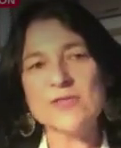

Female, detection=[0.9660891]





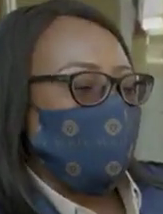

Female, detection=[0.55650735]





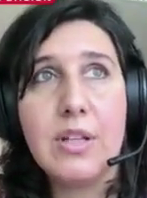

Female, detection=[0.9883061]





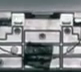

Female, detection=[8.227208e-05]





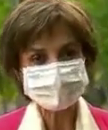

Female, detection=[0.8963705]





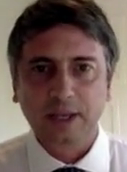

Male, detection=[0.99762684]





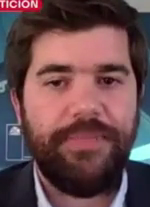

Male, detection=[0.98235404]





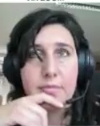

Female, detection=[0.99557173]





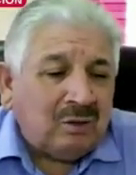

Male, detection=[0.98269385]





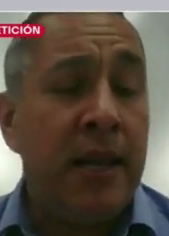

Male, detection=[0.98341215]





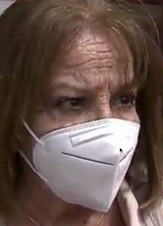

Female, detection=[0.93034106]





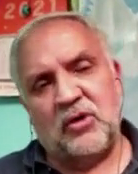

Male, detection=[0.9807422]





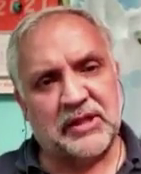

Male, detection=[0.9744878]





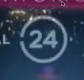

Male, detection=[0.00020139]





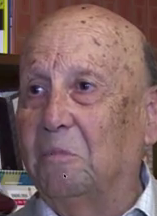

Male, detection=[0.9440835]





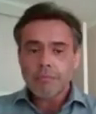

Male, detection=[0.99723536]





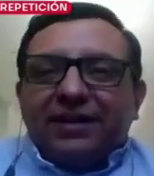

Male, detection=[0.9969881]





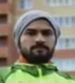

Male, detection=[0.00119838]





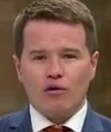

Male, detection=[0.9906679]





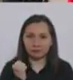

Female, detection=[0.00099054]





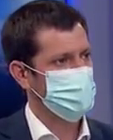

Male, detection=[0.98637563]





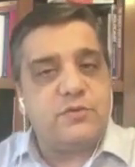

Male, detection=[0.97593]





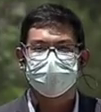

Male, detection=[0.01052856]





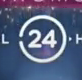

Female, detection=[2.916248e-05]





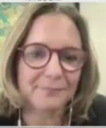

Female, detection=[0.9890143]





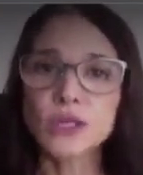

Female, detection=[0.98989666]





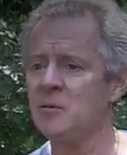

Male, detection=[0.99572587]





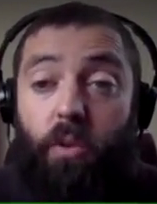

Male, detection=[0.96254474]





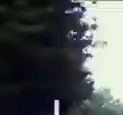

Male, detection=[0.00010523]





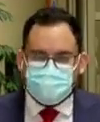

Male, detection=[0.00500952]





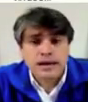

Male, detection=[0.8398911]





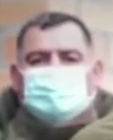

Female, detection=[0.00498029]





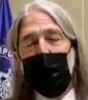

Female, detection=[0.02998312]





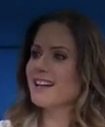

Female, detection=[0.998923]





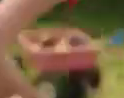

Female, detection=[2.949912e-06]





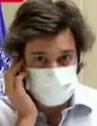

Female, detection=[0.38856366]





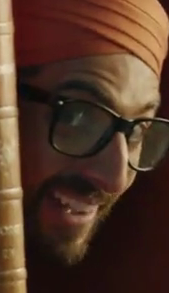

Male, detection=[0.05764174]





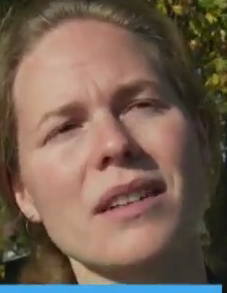

Female, detection=[0.9957094]





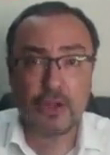

Male, detection=[0.9867132]





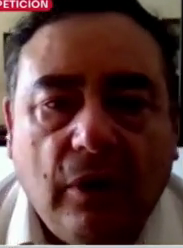

Male, detection=[0.9916243]





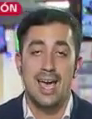

Male, detection=[0.9953269]





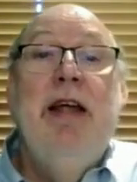

Male, detection=[0.8923342]





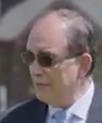

Male, detection=[0.9906951]





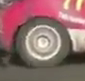

Female, detection=[2.8343171e-05]





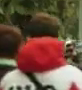

Female, detection=[3.3846016e-05]





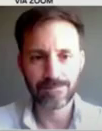

Male, detection=[0.9787508]





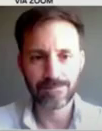

Male, detection=[0.95372486]





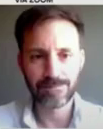

Male, detection=[0.9493159]





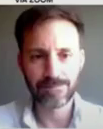

Male, detection=[0.91871196]





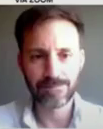

Male, detection=[0.9414058]





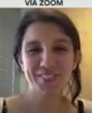

Female, detection=[0.98511016]





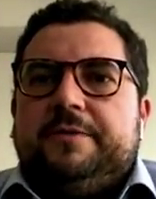

Male, detection=[0.99441683]





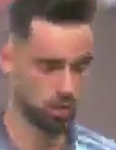

Male, detection=[0.7446105]





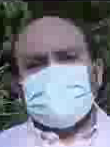

Female, detection=[0.30486888]





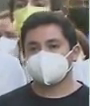

Male, detection=[0.96943855]





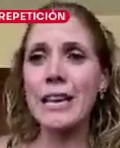

Female, detection=[0.99803597]





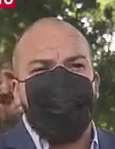

Female, detection=[0.03648973]





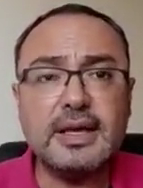

Male, detection=[0.9946668]





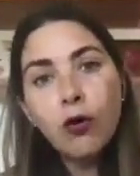

Female, detection=[0.98916596]





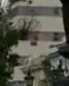

Female, detection=[2.9657367e-06]





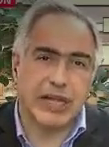

Male, detection=[0.96928394]





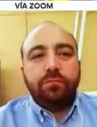

Male, detection=[0.96431226]





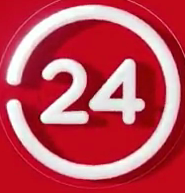

Female, detection=[0.00084915]





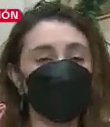

Female, detection=[0.03241475]





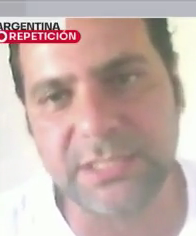

Male, detection=[0.9900531]





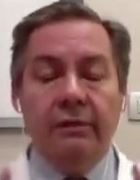

Male, detection=[0.9738854]





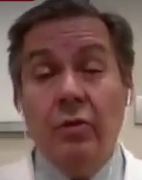

Female, detection=[0.9809472]





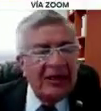

Male, detection=[0.9711383]





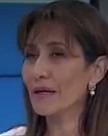

Female, detection=[0.9983735]





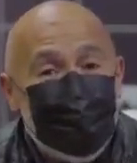

Male, detection=[0.00010804]





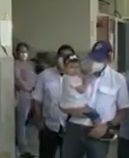

Female, detection=[2.165728e-07]





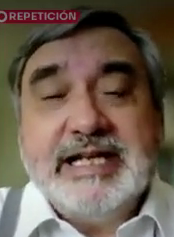

Male, detection=[0.9797769]





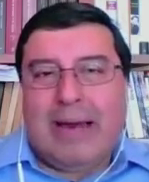

Male, detection=[0.9327404]





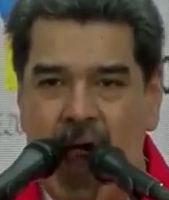

Male, detection=[0.99442923]





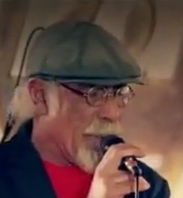

Male, detection=[0.8278685]





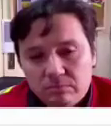

Male, detection=[0.990101]





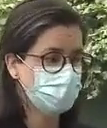

Female, detection=[0.41296396]





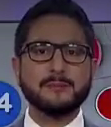

Male, detection=[0.9263054]





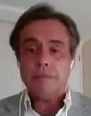

Male, detection=[0.9978928]





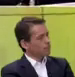

Male, detection=[1.7074495e-06]





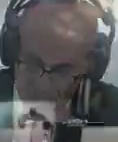

Female, detection=[0.00120548]





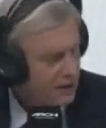

Male, detection=[0.87340456]





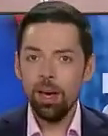

Male, detection=[0.9858888]





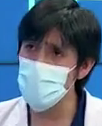

Male, detection=[0.00644378]





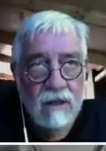

Male, detection=[0.9085476]





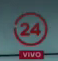

Female, detection=[0.05599263]





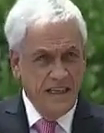

Male, detection=[0.9796556]





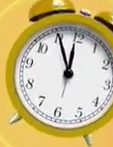

Female, detection=[0.00014847]





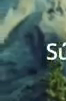

Female, detection=[4.311356e-06]





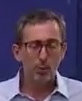

Male, detection=[0.9913366]





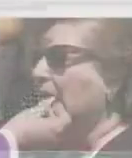

Female, detection=[0.6796096]





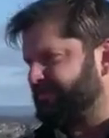

Male, detection=[0.3344232]





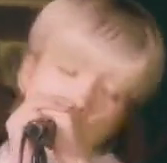

Male, detection=[0.0232662]





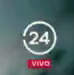

Female, detection=[2.8377304e-05]





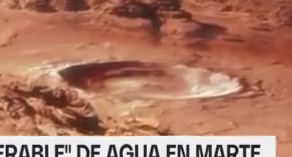

Female, detection=[5.4730743e-05]





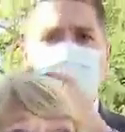

Male, detection=[0.00033009]





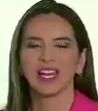

Female, detection=[0.9995461]





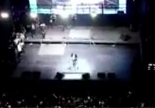

Female, detection=[2.2587452e-05]





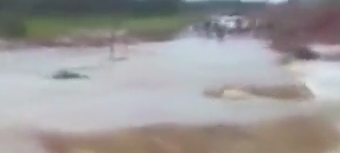

Female, detection=[0.00358686]





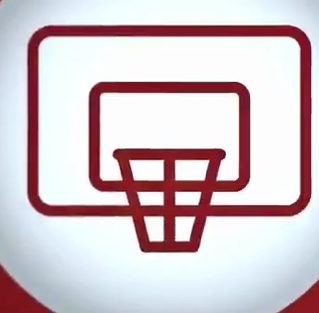

Male, detection=[9.315157e-06]





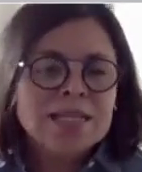

Female, detection=[0.98749334]





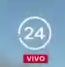

Female, detection=[0.00058966]





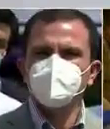

Male, detection=[0.08452287]





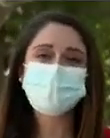

Female, detection=[0.95223385]





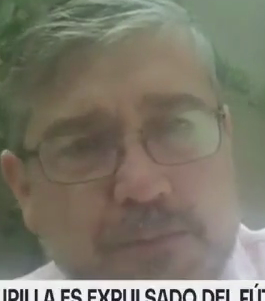

Male, detection=[0.916304]





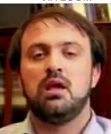

Male, detection=[0.96612865]





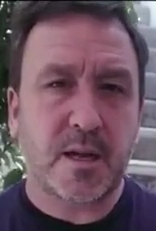

Male, detection=[0.9798815]





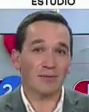

Male, detection=[0.9609341]





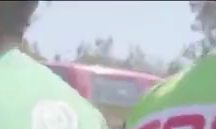

Female, detection=[1.8797532e-06]





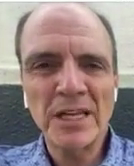

Male, detection=[0.98941565]





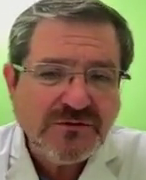

Male, detection=[0.98626757]





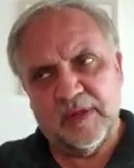

Male, detection=[0.9944554]





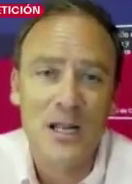

Male, detection=[0.9813059]





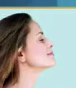

Female, detection=[0.99962413]





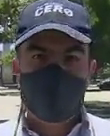

Male, detection=[0.00480953]





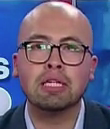

Male, detection=[0.9915051]





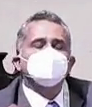

Male, detection=[0.7555513]





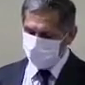

Male, detection=[0.00123401]





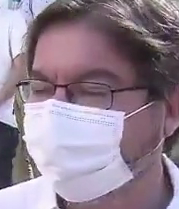

Female, detection=[0.65996987]





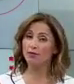

Female, detection=[0.99147475]





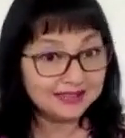

Female, detection=[0.9837572]





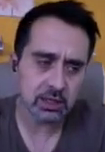

Male, detection=[0.9985191]





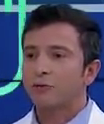

Male, detection=[0.9905193]





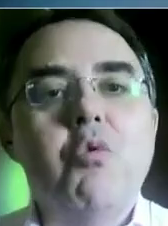

Male, detection=[0.907447]





In [26]:
for filename in os.listdir("/content/drive/MyDrive/ai/faces"):
    if not filename.endswith(".png"): 
        continue
    img_path = os.path.join("/content/drive/MyDrive/ai/faces", filename)
    image_swapped = io.imread(f"{img_path}") 
    image_2 = cv2.cvtColor(image_swapped, cv2.COLOR_BGR2RGB)
    cv2_imshow(image_2)
    print(short_hyperface('/content/noticias/hyperface/scripts/config.json',img_path,'/content/drive/MyDrive/ai/model_epoch_190'))
    print('\n\n') 